========================= SNR:  0.15
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_master': '', '_evaluation_master': '', '_task_type': None, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_environment': 'local', '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_is_chief': True, '_save_summary_steps': 50, '_num_worker_replicas': 0, '_model_dir': '/tmp/tf_lin', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2abdad9b8518>, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': 10000000000}
INFO:tensorflow:Calling model_fn.
================ P3F:  train (?, 4096)
================ logits:  train (?, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:

INFO:tensorflow:Calling model_fn.
================ P3F:  eval (?, 4096)
================ logits:  eval (?, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-12-18:11:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_lin/model.ckpt-1288
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-12-18:11:37
INFO:tensorflow:Saving dict for global step 1288: accuracy = 0.99852073, global_step = 1288, loss = 0.01084539
{'accuracy': 0.99852073, 'loss': 0.01084539, 'global_step': 1288}
========================= SNR:  0.025
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_master': '', '_evaluation_master': '', '_task_type': None, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_environment': 'local', '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_is_chief': Tr

SystemExit: 

/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


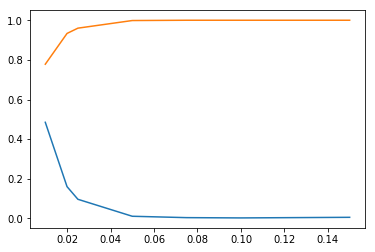

In [4]:
###
###  FIXME: This code can not be run 
###

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

N_DIGITS = 1
X_FEATURE = 'x'  # Name of the input feature.

RATE=4096
BATCH = 128
gloss = []
gacc = []

####
####   Network architecture
####
def conv_model(features, labels, mode):
  feature = tf.reshape(features[X_FEATURE], [-1, RATE,1])
  with tf.variable_scope('conv_layer1'):
    h_conv1 = tf.layers.conv1d(feature, filters=16, kernel_size=[16], padding='same', activation=tf.nn.relu)
    h_pool1 = tf.layers.max_pooling1d(h_conv1, pool_size=4, strides=4, padding='same', name='p1')
  with tf.variable_scope('conv_layer2'):
    h_conv2 = tf.layers.conv1d(h_pool1, filters=32, kernel_size=[8], padding='same', activation=tf.nn.relu)
    h_pool2 = tf.layers.max_pooling1d(h_conv2, pool_size=4, strides=4, padding='same', name='p2')
    #h_pool2 = tf.layers.batch_normalization(h_pool2n)
  with tf.variable_scope('conv_layer3'):
    h_conv3 = tf.layers.conv1d(h_pool2, filters=64, kernel_size=[8], padding='same', activation=tf.nn.relu)
    h_pool3 = tf.layers.max_pooling1d(h_conv3, pool_size=4, strides=4, padding='same', name='p3')
    #h_pool3 = tf.layers.batch_normalization(h_pool3n)
    
    dim = h_pool3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    h_pool3_flat = tf.reshape(h_pool3, [-1, fcnn])   ## linearize the matrix into 1D vector, =64*119
    print ("================ P3F: ", mode, h_pool3_flat.get_shape())

  # Densely connected layer
  h_fc1 = tf.layers.dense(h_pool3_flat, 64, activation=tf.nn.relu, name='d1')
  ### if mode == tf.estimator.ModeKeys.TRAIN: h_fc1 = tf.layers.dropout(h_fc1, rate=0.5)   ## dropout not used by Huerta

  ### 1-output  
  logits = tf.layers.dense(h_fc1, N_DIGITS, activation=None, name='d2')   ## No activation
  print ("================ logits: ", mode, logits.get_shape())

  # Compute predictions
   
  predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
  predict_op   = tf.round(predict_prob)  ## return largest index

  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'class': predict_op,
        'prob': predict_prob
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Create training op.
  loss = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=labels)
  #print ("================ loss: ", mode, loss.get_shape())

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_op  = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

  # Compute evaluation metrics.
  eval_metric_ops = {
      #'accuracy':  tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=labels)
      'accuracy': tf.metrics.accuracy(labels=labels, predictions=predict_op  )
  }
  return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

def prepare_data(SNR):
  N=2048
  N0=N//2
  L0=10  
  coor=np.linspace(0,L0,RATE)  
  X      = np.random.rand(N,RATE) - 0.5
  X[:N0] = X[:N0] + SNR*np.sin(2*np.pi*coor*((np.random.rand()+0.5)*2)/L0 )
  X      = X.astype(np.float32)
  y      = np.zeros(N)
  y[:N0] = np.ones(N0)
  #y      = y.astype(np.int32)
  y      = y.astype(np.float32).reshape(-1,1)
  return train_test_split(X, y, test_size=0.33, random_state=42) 

def CNN(SNR):
    tf.logging.set_verbosity(tf.logging.INFO)
    #tf.logging.set_verbosity(tf.logging.WARN)
    
    X_train, X_test, y_train, y_test = prepare_data(SNR)
    ### Download and load MNIST dataset.##mnist = tf.contrib.learn.datasets.DATASETS['mnist']('/tmp/mnist')
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = { X_FEATURE: X_train },  y = y_train,
        batch_size = BATCH,  ### step = N / Batch * epoches
        num_epochs = 30,  shuffle=True)
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = { X_FEATURE: X_test },   y= y_test,
        #batch_size = None,
        num_epochs=1,   shuffle=False)

    ########## CNN
    #try: os.remove('/tmp/tf_lin/checkpoint')  
    #except OSError: pass

    config = tf.contrib.learn.RunConfig(
        save_checkpoints_steps=10000000000,
        save_checkpoints_secs=None,
        save_summary_steps=50,
        #gpu_memory_fraction=0.5,
        model_dir='/tmp/tf_lin'
    )
    classifier = tf.estimator.Estimator(model_fn=conv_model, config=config)
    tensors_to_log = {"out_sigmoid": "sigmoid_tensor"}
    
    #logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=None,at_end=True)
    #classifier.train(input_fn=train_input_fn, steps=None, hooks=[logging_hook])
    
    classifier.train(input_fn=train_input_fn, steps=None)
    scores = classifier.evaluate(input_fn=test_input_fn, steps=None)
    
    """
    prediction = classifier.predict(input_fn=test_input_fn)
    i=0
    for p in prediction: 
        print (y_test[i], p)
        i = i+1
    """
    print(scores)  
    return scores['loss'], scores['accuracy']


    if 0:  
        ######### Linear classifier.
        feature_columns = [ tf.feature_column.numeric_column(X_FEATURE, shape=RATE) ]

        classifier = tf.estimator.LinearClassifier(feature_columns = feature_columns, n_classes=N_DIGITS)
        classifier.train(input_fn=train_input_fn, steps=None)
        scores = classifier.evaluate(input_fn=test_input_fn, steps=None)
        print("+++++ LC: ", scores)


def main(unused):
    
    try: os.remove('/tmp/tf_lin/checkpoint')  
    except OSError: pass

    #snr = [0.15,0.125,0.1,0.075,0.05,0.025, 0.02, 0.01,0.005, 0.002]
    snr = [0.15,0.1,0.075,0.05,0.025, 0.02, 0.01]
    #snr = [0.2]
    for x in snr:
        print("========================= SNR: ", x)
        l, a = CNN(x)
        gloss.append(l)
        gacc.append(a)
    print(gloss)
    print(gacc)
    plt.plot(snr,gloss)
    plt.plot(snr,gacc)
        
if __name__ == '__main__':
  tf.app.run()
  print("End-----------------")
   

In [ ]:
import numpy as np
import tensorflow as tf

DIM=4096
N=10000

X=np.random.rand(DIM,N)

np.random.shuffle(X[2])
print (X)


In [32]:
7+9

16

In [108]:
VEC = np.array(range(0,100))
LAB = [0]*10
LAB[:5]= [1]*5
LAB[0:3]
np.random.rand(2,3,1)


array([[[ 0.91426192],
        [ 0.2388273 ],
        [ 0.86361116]],

       [[ 0.42104202],
        [ 0.85576587],
        [ 0.95807103]]])

In [134]:
session = tf.get_default_session()
tf.one_hot([0,1,2], 2).eval(session=sess)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]], dtype=float32)

In [1]:
!nvidia-smi

Thu Mar  1 18:41:39 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   31C    P8     5W / 120W |     16MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106...  Off  | 00000000:84:00.0 Off |                  N/A |
| 28%   33C    P8     6W / 120W |     14MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [15]:
import tensorflow as tf
t = tf.constant([[1.,0.,4],[1.,0.,3],[0.,1.,1]])
s = tf.nn.softmax(t)
sess = tf.Session()
with tf.Session() as sess:
   #sess.run(tf.global_variables_initializer()) 
   print (t.eval())  # runs one step
   print (s.eval())  # runs one step


[[ 1.  0.  4.]
 [ 1.  0.  3.]
 [ 0.  1.  1.]]
[[ 0.04661262  0.01714783  0.93623954]
 [ 0.11419519  0.04201007  0.8437947 ]
 [ 0.15536241  0.42231882  0.42231882]]


In [12]:
import numpy as np
a=np.exp(-1)
b=np.exp(0)
print (a/(a+b))
print (b/(a+b))

0.26894142137
0.73105857863


In [8]:
np.floor(0.49+0.5)


0.0

In [2]:
a = { 'bbb': [1,2,3] }
a['bbb']

[1, 2, 3]